# LSI Word Embedding using K-means, Gaussian Mixture and Cosine Similarity as Clustering

In [147]:
import os.path

from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# from clustering_class import *
# from new_combine_models import *
# from DEC import *
# from generate_word_vector import *

from tqdm.notebook import tqdm, tnrange
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [148]:
pd.set_option('display.max_rows', 50)
plt.rcParams['figure.figsize'] = [17, 6]
plt.rcParams.update({'font.size': 12})

In [149]:
%%html
<style>
table {float:center}
</style>

In [150]:
def preprocess_data(doc_list):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    tokenizer = RegexpTokenizer(r'\w+')
    en_stop = set(stopwords.words('english'))# create English stop words list
    p_stemmer = PorterStemmer()
    processed_doc_list = []

    for doc in doc_list:
        lower_doc = doc.lower()
        token_list = tokenizer.tokenize(lower_doc)
        stopped_token_list = [i for i in token_list if not i in en_stop]
        stemmed_token_list = [p_stemmer.stem(i) for i in stopped_token_list]
        processed_doc = ' '.join(stemmed_token_list) # Untokenize
        processed_doc_list.append(processed_doc)
    
    return processed_doc_list

In [345]:
snp_desc_10K_df = pd.read_pickle('data_out/snp_desc_10K.pkl')

In [346]:
snp_desc_10K_df.head()

,CIK,Description
AAL,0000004515,PART I ITEM 1. BUSINESS Overview American ...
AAPL,0000320193,PART I Item 1.Business Company Background T...
AAP,0001158449,PART I Item 1. Business. Unless the context ...
ABBV,0001551152,PART I ITEM 1. BUSINESS Overview AbbVie(1) ...
ABC,0001140859,PART I ITEM 1. BUSINESS As used herein the ...


In [151]:
df = pd.read_csv('yahoo_spiders/data_out/yahoo_desc.csv', ).dropna().reset_index(drop=True)

df.Industry = pd.Categorical(df.Industry)
df.Sector = pd.Categorical(df.Sector)

In [152]:
df.head()

,Ticker,Description,Sector,Industry
0,ABT,"Abbott Laboratories discovers, develops, manuf...",Healthcare,Medical Devices
1,ACN,"Accenture plc provides consulting, technology,...",Technology,Information Technology Services
2,MMM,"3M Company develops, manufactures, and markets...",Industrials,Specialty Industrial Machinery
3,ABMD,"Abiomed, Inc. engages in the research, develop...",Healthcare,Medical Devices
4,ADBE,Adobe Inc. operates as a diversified software ...,Technology,Software—Infrastructure


In [153]:
df.shape

(438, 4)

In [154]:
len(set(df.Sector))

11

In [155]:
len(set(df.Industry))

109

In [156]:
df.iloc[1].Description

"Accenture plc provides consulting, technology, and outsourcing services worldwide. Its Communications, Media & Technology segment provides professional services for clients to accelerate and deliver digital transformation, develop industry-specific solutions, and enhance efficiencies and business results for communications, media, high tech, software, and platform companies. The company's Financial Services segment offers services for profitability pressures, industry consolidation, regulatory changes, and the need to continually adapt to new digital technologies for banking, capital market, and insurance industries. Its Health & Public Service segment provides consulting services and digital solutions to help clients deliver social, economic, and health outcomes for healthcare payers and providers, government departments and agencies, public service organizations, educational institutions, and non-profit organizations. The company's Products segment helps clients enhance their perfor

In [157]:
desc_list = df['Description']

##### Pre Processing

In [158]:
preped_desc_list = preprocess_data(desc_list)

In [159]:
len(preped_desc_list)

438

##### Tdidf vectorization

In [160]:
vectorizer = TfidfVectorizer(stop_words='english', max_features= None, max_df = 0.5, smooth_idf=True)
dtm = vectorizer.fit_transform(preped_desc_list) # dtm - Document Matrix (sparse matrix)
dtm.shape

(438, 7263)


| Index | Unique Words (features)
| :- | -: | 
| Russell | 20025 |
| SnP | 7263 |

# Clustering Algos

In [161]:
NUM_INDUSTRIES = 109 #69

### K - Means

In [58]:
# defining the kmeans function with initialization as k-means++
kmeans = KMeans(n_clusters=NUM_INDUSTRIES, init='k-means++')
# fitting the k means algorithm on scaled data
kmeans.fit(dtm_lsa)
pred = kmeans.predict(dtm_lsa)
# pd.concat([df[['company']], pd.DataFrame(pred)], axis=1).head()
pred

array([10, 53,  8, 19, 43, 43, 50, 43, 52, 10,  2, 17,  3, 60, 42, 40, 48,
       39, 27, 20, 17, 56,  3, 59, 43, 40, 17, 41, 56, 39, 64, 24, 28, 38,
       30, 50,  2, 28,  2, 64, 26, 25, 23, 14, 67, 37,  3, 56, 56, 62, 13,
       28, 18, 52, 23, 33,  8, 51, 63,  6, 50,  5, 25, 12, 44, 34, 39, 19,
       16, 21, 38, 68, 26,  9, 30, 63, 24, 14, 54, 36, 34, 31, 61, 62, 38,
        5, 60,  6, 13, 11, 46, 65,  2, 63, 56, 63,  8, 28, 31, 46, 62, 64,
       53,  9,  9, 26, 13, 62, 26, 59, 24, 14, 25,  0, 67, 38, 37, 34, 55,
       20, 65,  5, 10, 29, 26, 27, 40, 26, 16, 13, 13, 41, 25, 13, 62, 57,
        1, 62, 17, 61, 35, 67, 53, 34,  6, 31, 64, 61, 62, 19, 43, 28, 17,
       26, 21, 23, 23,  5, 17, 12, 56, 17, 15,  3, 11, 29, 35, 43, 68, 21,
       63, 63,  4, 41,  0,  1, 41, 14,  3,  4, 20, 13, 13, 31, 22,  9, 16,
       53, 14, 44,  2, 29, 41,  6, 29, 20, 33, 32, 43,  5, 56, 39, 27, 26,
       47, 28, 42, 10, 58,  9, 39, 44, 67,  2, 63, 22,  1, 29, 10, 48, 30,
        1, 53, 31, 51, 37

In [15]:
def kmeans_cluster(dtm):
    '''
    input: Document Matrix
    output: list indicating clusters
    '''
    kmeans = KMeans(n_clusters=NUM_INDUSTRIES, init='k-means++')
    kmeans.fit(dtm)
    pred = kmeans.predict(dtm)
    return pred

### Gaussian Mixture

In [16]:
def gmm_cluster(dtm):
    '''
    input: Document Matrix
    output: list indicating clusters
    '''
    gmm = GaussianMixture(n_components=NUM_INDUSTRIES)
    gmm.fit(dtm)
    pred = gmm.predict(dtm)
    return pred

### Cosine Similarity

In [ ]:
x = [((1,),(2,),3), ((4,),(1458,),6)]

mcorr = ((1458,), (1830,), 1.0000000000000004)
list(filter(lambda tup: (tup[0] not in mcorr) and (tup[1] not in mcorr), x))

In [ ]:
((1,2), (4,)) in (1,)

In [61]:
def cosine_similarity(dtm):
    '''
    input: Doc Matrix
    output: list of lists indicating clusters
    '''
    corr = np.asarray(np.asmatrix(dtm) * np.asmatrix(dtm).T)
    L = corr.shape[0]
    
    cluster_corrs = []
    for i in range(L):
        for j in range(i+1,L):
            corr_tuple = ((i,), (j,), corr[i][j])
            cluster_corrs.append(corr_tuple)
            
    cluster_list = [(i,) for i in range(L)]
    
    num_iter = L - NUM_INDUSTRIES
    for x in range(num_iter):
        max_corr_tup = max(cluster_corrs, key = lambda tup: tup[2])
        # filters ur max_corr_tup also
        print(max_corr_tup)
        cluster_corrs = list(filter(lambda tup: (tup[0] not in max_corr_tup) and (tup[1] not in max_corr_tup),cluster_corrs))
        new_cluster = max_corr_tup[0] + max_corr_tup[1] # concatenate tups
        cluster_list.remove(max_corr_tup[0])
        cluster_list.remove(max_corr_tup[1])
        for cluster in cluster_list:
            # Similarity
            n = len(new_cluster) * len(cluster)
            total_similarity = 0
            for cpy_1 in new_cluster:
                for cpy_2 in cluster:
                    total_similarity += corr[cpy_1][cpy_2]
            similarity = total_similarity / n
            corr_tuple = (new_cluster, cluster, similarity)
            cluster_corrs.append(corr_tuple)
        cluster_list.append(new_cluster)
    
    if len(cluster_list) != NUM_INDUSTRIES:
        raise Exception()
        
    pred = np.full(N, -1)
    for i in range(NUM_INDUSTRIES):
        cluster = list(cluster_list[i])
        pred[cluster] = [i] * len(cluster)
    return pred

In [62]:
cosine_similarity(dtm_lsa)

((299,), (301,), 1.0000000000000007)
((400,), (401,), 1.0000000000000002)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
dtmx = dtm_lsa
corr = np.asarray(np.asmatrix(dtmx) * np.asmatrix(dtmx).T)
L = corr.shape[0]

cluster_corrs = []
for i in range(L):
    for j in range(i+1,L):
        corr_tuple = ((i,), (j,), corr[i][j])
        cluster_corrs.append(corr_tuple)

cluster_list = [(i,) for i in range(L)]

num_iter = L - NUM_INDUSTRIES
for x in range(num_iter):
    max_corr_tup = max(cluster_corrs, key = lambda tup: tup[2])
    # filters ur max_corr_tup also
    print(max_corr_tup)
    cluster_corrs = list(filter(lambda tup: (tup[0] not in max_corr_tup) and (tup[1] not in max_corr_tup),cluster_corrs))
    new_cluster = max_corr_tup[0] + max_corr_tup[1] # concatenate tups
    cluster_list.remove(max_corr_tup[0])
    cluster_list.remove(max_corr_tup[1])
    for cluster in cluster_list:
        # Similarity
        n = len(new_cluster) * len(cluster)
        total_similarity = 0
        for cpy_1 in new_cluster:
            for cpy_2 in cluster:
                total_similarity += corr[cpy_1][cpy_2]
        similarity = total_similarity / n
        corr_tuple = (new_cluster, cluster, similarity)
        cluster_corrs.append(corr_tuple)
    cluster_list.append(new_cluster)

if len(cluster_list) != NUM_INDUSTRIES:
    raise Exception()

pred = np.full(N, -1)
for i in range(NUM_INDUSTRIES):
    cluster = list(cluster_list[i])
    pred[cluster] = [i] * len(cluster)

In [ ]:
def t(tup):
    print((tup[0] not in max_corr_tup), (tup[1] not in max_corr_tup))
    return (tup[0] not in max_corr_tup) and (tup[1] not in max_corr_tup)
list(filter(t,cluster_corrs))

### Run all Clustering algos

In [162]:
dtm.shape

(438, 7263)

In [206]:
gics_df = pd.DataFrame(df.Industry.cat.codes, columns=['GICS'])
cluster_dfs_list = [df[['Ticker']], gics_df]
for k in tnrange(100, 110, 10):
#     print(k)
    lsa_k = TruncatedSVD(k, algorithm = 'arpack')
    dtm_lsa_k = lsa_k.fit_transform(dtm)
    dtm_lsa_k = Normalizer(copy=False).fit_transform(dtm_lsa_k)
    # K-Means
    clusters_k = kmeans_cluster(dtm_lsa_k)
    cluster_dfs_list.append(pd.DataFrame(clusters_k, columns=['lsi_{}_kmeans'.format(str(k))]))
    # GMM
    clusters_k = gmm_cluster(dtm_lsa_k)
    cluster_dfs_list.append(pd.DataFrame(clusters_k, columns=['lsi_{}_gmm'.format(str(k))]))
    # Cosine_similarity
    
all_cluster = pd.concat(cluster_dfs_list, axis=1)

In [207]:
all_cluster.head()

,Ticker,GICS,lsi_100_kmeans,lsi_100_gmm
0,ABT,63,58,36
1,ACN,49,1,2
2,MMM,95,76,104
3,ABMD,63,23,20
4,ADBE,92,87,12


## Evaluation

### Method 1 - Stock returns correlations

In [165]:
stock_price_df =pd.read_csv('data_out/ticker_price_df.csv', index_col=0)

In [166]:
stock_return_df = stock_price_df.pct_change()
stock_return_df.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2018-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,-0.026238,0.011523,0.002921,0.001141,-0.032108,0.000672,-0.046394,-0.039126,-0.002979,-0.007382,...,0.019725,0.021997,0.018275,0.018725,-0.003147,-0.005222,-0.013883,-0.018778,0.020618,-0.012392
2019-01-03,-0.036840,-0.074507,0.031218,-0.099607,-0.032949,-0.014506,-0.024745,-0.047194,-0.034142,-0.039498,...,-0.037651,-0.015354,0.000528,-0.021858,-0.034281,-0.025153,-0.018088,-0.059908,-0.005531,-0.034565
2019-01-04,0.034614,0.065868,-0.024808,0.042689,0.032217,0.011585,0.036885,0.028541,0.038884,0.048632,...,0.046303,0.036869,0.029016,0.038598,0.042192,0.026026,0.034153,0.041462,0.030713,0.039235
2019-01-07,0.021234,0.028402,0.014672,-0.002226,0.014595,0.007141,0.004339,0.014976,0.003473,0.013573,...,0.026415,0.005200,0.017944,0.021516,-0.014789,-0.001093,0.000385,0.015166,0.003989,0.006017


In [167]:
# Tickers to remove if no stock data
tickers_with_no_data = [ticker for ticker in all_cluster.Ticker if ticker not in stock_return_df.columns]
tickers_with_no_data

['CARR', 'OTIS']

In [168]:
all_cluster_filtered = all_cluster[~all_cluster.Ticker.isin(tickers_with_no_data)].reset_index(drop=True)
all_cluster_filtered.head()

,Ticker,GICS,lsi_10_kmeans,lsi_10_gmm,lsi_20_kmeans,lsi_20_gmm,lsi_30_kmeans,lsi_30_gmm,lsi_40_kmeans,lsi_40_gmm,...,lsi_80_kmeans,lsi_80_gmm,lsi_90_kmeans,lsi_90_gmm,lsi_100_kmeans,lsi_100_gmm,lsi_110_kmeans,lsi_110_gmm,lsi_120_kmeans,lsi_120_gmm
0,ABT,63,42,15,66,33,27,52,15,61,...,78,11,70,8,55,62,15,104,5,55
1,ACN,49,2,93,79,89,97,1,27,32,...,57,8,83,36,35,5,54,24,102,1
2,MMM,95,83,88,57,72,19,28,19,82,...,54,60,86,62,9,16,28,14,69,10
3,ABMD,63,105,67,73,30,87,22,105,18,...,38,61,24,29,17,30,46,25,57,27
4,ADBE,92,59,25,82,97,46,58,59,108,...,103,68,75,102,90,21,94,71,65,107


In [169]:
R2_dict = {}

for cluster_mtd in tqdm(all_cluster_filtered.columns):
    if cluster_mtd == 'Ticker':
        continue
    
#     print(cluster_mtd)
    R2_list = []
    for i in range(NUM_INDUSTRIES):
        cluster_tickers = all_cluster_filtered[all_cluster_filtered[cluster_mtd] == i].Ticker
        cluster_stock_returns = stock_return_df[cluster_tickers]
        mean_return = cluster_stock_returns.mean(axis=1)
        cluster_R2 = [mean_return.corr(ticker_returns) for _, ticker_returns in cluster_stock_returns.iteritems()]
        R2_list.extend(cluster_R2)
#     print(R2_list)
    avg_R2 = sum(R2_list)/len(R2_list)
    R2_dict[cluster_mtd] = avg_R2

avg_R2_df = pd.DataFrame.from_dict(R2_dict, orient='index', columns=['Average R2'])

In [170]:
avg_R2_df

,Average R2
GICS,0.784937
lsi_10_kmeans,0.754978
lsi_10_gmm,0.754518
lsi_20_kmeans,0.771147
lsi_20_gmm,0.773206
lsi_30_kmeans,0.775576
lsi_30_gmm,0.772410
lsi_40_kmeans,0.774178
lsi_40_gmm,0.775367
lsi_50_kmeans,0.775688


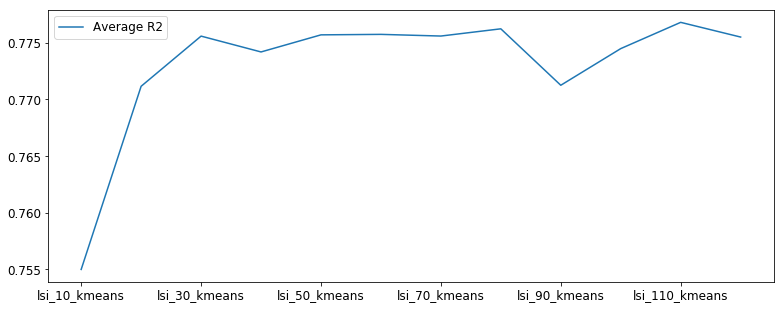

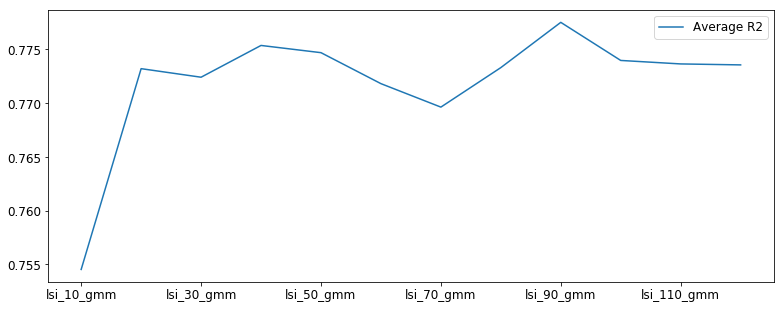

In [171]:
avg_R2_df.filter(regex='kmeans', axis=0).plot(figsize=(13,5))
avg_R2_df.filter(regex='gmm', axis=0).plot(figsize=(13,5))

### Method 2a - Financial Ratio average cluster distance (simple average)

- Need to handle missing values of ratios

In [282]:
stock_ratios_df = pd.read_csv('data_out/ticker_ratios_df.csv', index_col=0)

In [285]:
stock_ratios_df

,Ticker,mkt_cap,pb_ratio,beta,profit_margin,ROA,ROE
0,MMM,89.85,8.80,0.97,0.1637,0.0993,0.4881
1,ABT,161.88,5.36,0.95,0.0989,0.0401,0.0986
2,ABBV,173.22,NaN,0.72,0.1920,0.0823,2.2562
3,ABMD,10.88,10.21,1.14,0.1988,0.1176,0.1508
4,ACN,128.62,8.29,1.02,0.1111,0.1293,0.3282
...,...,...,...,...,...,...,...
498,YUM,26.16,NaN,0.86,0.1878,0.1981,NaN
499,ZBRA,13.65,7.90,1.52,0.1141,0.0904,0.2939
500,ZBH,24.70,2.08,1.38,0.0052,0.0224,0.0031
501,ZION,5.58,0.81,1.61,0.2046,0.0066,0.0639


In [288]:
# Normalise values
stock_ratios_normalised_df = stock_ratios_df.copy()
for header in stock_ratios_df.columns[1:]:
    col = stock_ratios_df[header]
    stock_ratios_normalised_df[header] = (col - col.mean())/col.std()
stock_ratios_normalised_df

,Ticker,mkt_cap,pb_ratio,beta,profit_margin,ROA,ROE
0,MMM,0.242888,-0.013788,-0.258392,0.254488,0.933246,0.027070
1,ABT,0.753927,-0.074094,-0.295916,-0.012938,-0.246306,-0.089322
2,ABBV,0.834382,NaN,-0.727440,0.371281,0.594524,0.555420
3,ABMD,-0.317389,0.010930,0.060560,0.399344,1.297871,-0.073724
4,ACN,0.517954,-0.022729,-0.164583,0.037411,1.530992,-0.020712
...,...,...,...,...,...,...,...
498,YUM,-0.208980,NaN,-0.464773,0.353947,2.901823,NaN
499,ZBRA,-0.297736,-0.029566,0.773512,0.049791,0.755915,-0.030962
500,ZBH,-0.219338,-0.131594,0.510846,-0.399633,-0.598976,-0.117860
501,ZION,-0.354991,-0.153858,0.942369,0.423280,-0.913789,-0.099691


In [289]:
# Tickers to remove if no ratio data
tickers_with_no_data = [ticker for ticker in all_cluster.Ticker if ticker not in list(stock_ratios_df.Ticker)]
tickers_with_no_data

[]

In [300]:
all_cluster_filtered = all_cluster[~all_cluster.Ticker.isin(tickers_with_no_data)].reset_index(drop=True)
all_cluster_filtered.head()

,Ticker,GICS,lsi_100_kmeans,lsi_100_gmm
0,ABT,63,58,36
1,ACN,49,1,2
2,MMM,95,76,104
3,ABMD,63,23,20
4,ADBE,92,87,12


In [269]:
def cluster_distance(s):
    '''
    input: series
    output: sum(x - x_bar), sum of absolute distances to cluster center
    '''
    mean = s.mean() #ignores NaN values
    abs_dist = abs(s-mean).sum()
    return abs_dist

In [323]:
RATIO_NAMES_LIST = list(stock_ratios_df.columns[1:])
all_cluster_with_ratio = pd.merge(all_cluster_filtered, stock_ratios_df, on='Ticker')
ratio_distances_dict = {}

for cluster_mtd in tqdm(all_cluster_filtered.columns):
    if cluster_mtd == 'Ticker':
        continue
    
    filter_df = all_cluster_with_ratio[[cluster_mtd] + RATIO_NAMES_LIST]
    ratio_distance_sum = filter_df.groupby(cluster_mtd).aggregate(cluster_distance).sum()
    non_na_count_series = filter_df.count()[1:]
    ratio_distance_avg_list = list(ratio_distance_sum/non_na_count_series)
    ratio_distances_dict[cluster_mtd] = ratio_distance_avg_list
    
ratio_distances_df = pd.DataFrame.from_dict(ratio_distances_dict, orient='index', columns=RATIO_NAMES_LIST)

In [324]:
ratio_distances_df['Average Ratio Cluster Spread'] = ratio_distances_df.mean(axis=1)
ratio_distances_df

,mkt_cap,pb_ratio,beta,profit_margin,ROA,ROE,Average Ratio Cluster Spread
GICS,32.589431,10.434754,0.223470,0.087788,0.024529,0.239094,7.266511
lsi_100_kmeans,41.368100,10.205242,0.234881,0.092872,0.024468,0.526192,8.741959
lsi_100_gmm,41.465376,9.551720,0.224544,0.092571,0.024313,0.555863,8.652398


### Method 2b - Financial Ratio average cluster distance (averaged by mkt cap)

### Method 3 - Majority element ratios (my method)

In [29]:
all_cluster.head()

,Ticker,GICS,lsi_10_kmeans,lsi_10_gmm,lsi_20_kmeans,lsi_20_gmm,lsi_30_kmeans,lsi_30_gmm,lsi_40_kmeans,lsi_40_gmm,...,lsi_380_kmeans,lsi_380_gmm,lsi_390_kmeans,lsi_390_gmm,lsi_400_kmeans,lsi_400_gmm,lsi_410_kmeans,lsi_410_gmm,lsi_420_kmeans,lsi_420_gmm
0,ABT,63,31,5,79,56,62,22,20,98,...,8,108,58,103,15,65,57,53,18,6
1,ACN,49,106,2,71,102,77,62,93,5,...,17,72,102,92,98,82,3,90,63,3
2,MMM,95,78,96,56,45,31,35,68,55,...,4,7,26,61,46,20,64,62,24,69
3,ABMD,63,78,96,7,47,13,23,27,69,...,24,48,65,32,34,12,24,46,11,11
4,ADBE,92,51,24,42,93,90,37,3,47,...,78,25,44,62,98,41,68,69,14,45


In [55]:
# Test
all_cluster[all_cluster.GICS ==3][['GICS', 'lsi_110_kmeans', 'lsi_110_gmm']]

,GICS,lsi_110_kmeans,lsi_110_gmm
15,3,100,54
25,3,100,54
126,3,100,54
371,3,100,54
404,3,38,54


In [52]:
def majority_element_proportion(s):
    '''
    input: series
    output: proportion of majority element in series
    '''
    l = len(s)
    n = s.value_counts().iloc[0]
    return n/l

In [337]:
correctness_ratios_df = all_cluster.iloc[:,1:].groupby('GICS').aggregate(majority_element_proportion)

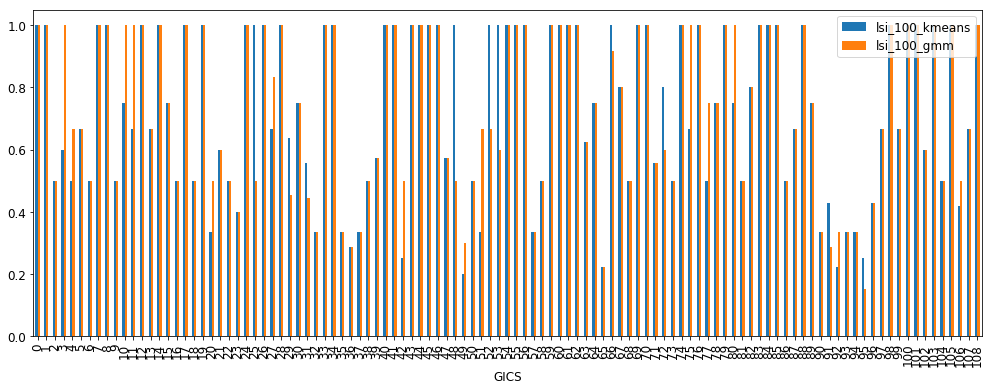

In [338]:
correctness_ratios_df.plot.bar()
# sns.barplot(correctness_ratios_df)

c:\users\sival\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


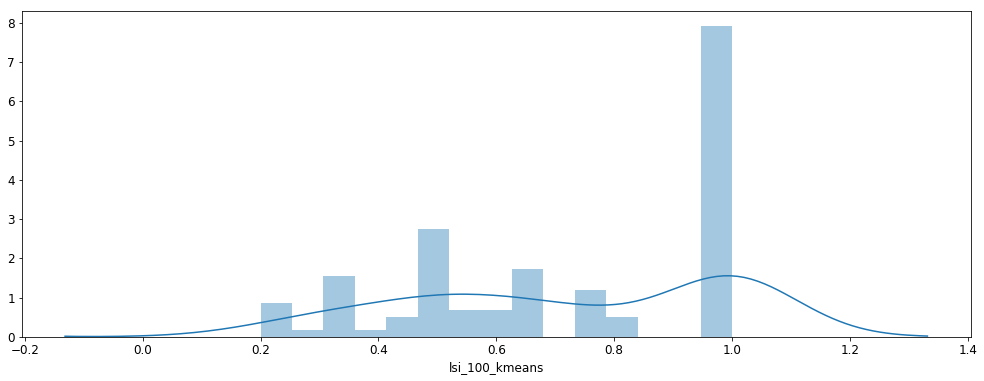

In [341]:
sns.distplot(correctness_ratios_df.iloc[:,0], bins=15)

- Since most of the ratios seem to be above the 0.5 ratio, the clustring seems to have clustered pretty closely to GICS standard

# Extra

### Tests

##### LSA Word Embedding (Test, Actual For loop is below)

In [106]:
lsa = TruncatedSVD(200, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(dtm)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa) # normalisae so each vector is len 1

In [107]:
pd.DataFrame(dtm_lsa).head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.186027,-0.063461,-0.212476,0.132797,0.086120,0.222043,0.301794,0.259920,-0.031192,0.080088,...,-0.067338,0.004449,-0.056364,-0.038719,-0.017974,-0.009489,0.007618,0.073074,-0.008122,0.052722
1,0.401177,-0.015788,-0.164992,-0.057852,0.110736,-0.037090,-0.000830,0.066506,-0.030720,-0.064347,...,0.126713,-0.066480,-0.001598,-0.062942,-0.011841,-0.032356,0.002961,0.006440,0.045562,-0.038511
2,0.324800,-0.131666,-0.206526,0.105576,-0.036015,0.238173,0.060495,0.028622,-0.039046,-0.012727,...,-0.005368,0.030757,-0.042402,0.006760,-0.032632,0.000339,-0.027574,-0.002905,-0.015595,-0.019584
3,0.110320,-0.053520,-0.118458,-0.013129,0.035338,0.047525,0.083328,0.038494,0.032770,0.062653,...,-0.049930,-0.051575,0.153006,-0.111204,0.006802,-0.052839,0.030731,0.022081,0.072314,0.070727
4,0.267790,-0.002623,-0.201545,-0.078364,-0.025053,-0.240672,-0.079426,0.104835,-0.052271,-0.000145,...,-0.008892,-0.023900,-0.023031,0.017898,-0.017054,0.032710,0.074666,0.017683,0.000755,-0.039082


### Previous Code

|Embedding model|R2|proportion of right classification|
|----------------|--------|--------|
| LSI length 200 | 0.4537 | 0.4962 |
| LSI length 300 | 0.4459 | 0.4768 |
| LSI length 400 | 0.4421 | 0.4072 |
| LSI length 500 | 0.4554 | 0.4244 |
| LSI length 600 | 0.4362 | 0.4409 |
| LSI length 700 | 0.4407 | 0.3842 |
| LSI length 800 | 0.4417 | 0.4921 |
| LSI length 900 | 0.4478 | 0.4005 |
| LSI length 1000 | 0.4403 | 0.4068 |
| LSI length 1100 | 0.4380 | 0.3933 |

- not sure why in their code, the classes number is not 69

In [ ]:
performance.plot_industry_dense()

In [31]:
ratio_df = pd.read_csv('data/russell3000_ratios.csv')
def multiplier(num):
    out=np.nan
    if num[-1]=='B':
        out=float(num[:-1])*1000
    elif num[-1]=='T':
        out=float(num[:-1])*1000*1000
    elif num[-1]=='M':
        out=float(num[:-1])
    return out
ratio_df['mkt_cap']=ratio_df['mkt_cap'].map(multiplier)
ratio_df['beta'] = pd.to_numeric(ratio_df['beta'],errors='coerce')
ratio_df['profit_m']=ratio_df['profit_m'].map(lambda x: float(x.strip('%').replace(',',''))/100 if not pd.isnull(x) else np.nan)
ratio_df['roa']=ratio_df['roa'].map(lambda x: float(x.strip('%').replace(',',''))/100 if not pd.isnull(x) else np.nan)
ratio_df['roe']=ratio_df['roe'].map(lambda x: float(x.strip('%').replace(',',''))/100 if not pd.isnull(x) else np.nan)
charic_names=list(ratio_df.columns[2:])
ratio_df.dropna(inplace=True)

In [32]:
cluster_names=list(all_cluster.columns[1:])
all_df=all_cluster.merge(ratio_df,how='inner',on='company')

In [33]:
eval_df=pd.DataFrame(columns=['clustering']+charic_names)
total_comp=all_df.shape[0]
charic_total=[]
for r in range(len(charic_names)):
    charic_total.append(ratio_df['mkt_cap'].dot(ratio_df.iloc[:,r+2]))
charic_total=charic_total/ratio_df['mkt_cap'].sum()
cl_results=[]
for cl in range(len(cluster_names)):
    cl_res=[cluster_names[cl]]
    for r in range(len(charic_names)):
        clr_df=all_df.loc[:,[cluster_names[cl],charic_names[r],'mkt_cap']]
        clr_df['sumpro']=clr_df[charic_names[r]]*clr_df['mkt_cap']
        clr_df=clr_df.groupby(cluster_names[cl]).agg({charic_names[r]:'count','mkt_cap':'sum','sumpro':'sum'})
        clr_df['sigma']=clr_df[charic_names[r]]/np.sum(clr_df[charic_names[r]])*(clr_df['sumpro']/clr_df['mkt_cap']-charic_total[r])**2
        clr=np.sqrt(clr_df['sigma'].sum())
        cl_res.append(clr)
    cl_results.append(cl_res)
eval_df=eval_df.append(pd.DataFrame(cl_results,columns=eval_df.columns))
eval_df['average']=eval_df.mean(1)
eval_df.set_index('clustering',inplace=True)
eval_df=eval_df.sort_values('average', ascending=False)
print('Market value weighted:')
print(eval_df)

Market value weighted:
                 pb_ratio      beta  profit_m       roa       roe   average
clustering                                                                 
lsi_400_gmm     10.640692  0.338565  0.144305  0.052437  1.808450  2.596890
lsi_500_kmeans   9.826530  0.300953  0.128645  0.048725  2.046703  2.470311
lsi_200_gmm     10.232821  0.315177  0.146739  0.060368  1.020367  2.355094
lsi_300_kmeans   8.713562  0.313041  0.131408  0.052699  2.498582  2.341858
lsi_600_gmm      9.329555  0.288173  0.131433  0.053440  0.873638  2.135248
lsi_200_kmeans   7.531815  0.301557  0.128854  0.062301  1.811218  1.967149
lsi_500_gmm      6.879473  0.311960  0.141205  0.061411  1.814388  1.841687
lsi_600_kmeans   6.865131  0.321986  0.152246  0.059960  1.803690  1.840603
lsi_300_gmm      6.714773  0.311362  0.154679  0.044518  1.786671  1.802401
lsi_400_kmeans   6.307048  0.308758  0.130515  0.045149  2.171495  1.792593


In [34]:
eval_df=pd.DataFrame(columns=['clustering']+charic_names)
total_comp=all_df.shape[0]
charic_total=[]
for r in range(len(charic_names)):
    charic_total.append(ratio_df.iloc[:,r+2].mean())
cl_results=[]
for cl in range(len(cluster_names)):
    cl_res=[cluster_names[cl]]
    for r in range(len(charic_names)):
        clr_df=all_df.loc[:,[cluster_names[cl],charic_names[r]]]
        clr_df=clr_df.groupby(cluster_names[cl]).agg(['count','mean'])
        clr_df=clr_df[clr_df[(charic_names[r],'count')]>=5]
        clr_df['sigma']=clr_df[(charic_names[r],'count')]/np.sum(clr_df[(charic_names[r],'count')])*(clr_df[(charic_names[r],'mean')]-charic_total[r])**2
        clr=np.sqrt(clr_df['sigma'].sum())
        cl_res.append(clr)
    cl_results.append(cl_res)
eval_df=eval_df.append(pd.DataFrame(cl_results,columns=eval_df.columns))
eval_df['average']=eval_df.mean(1)
eval_df.set_index('clustering',inplace=True)
eval_df=eval_df.sort_values('average', ascending=False)
print('Equal value weighted:')
print(eval_df)

Equal value weighted:
                pb_ratio      beta  profit_m       roa       roe   average
clustering                                                                
lsi_500_kmeans  3.733019  0.411994  0.176020  0.073677  3.165244  1.511991
lsi_400_kmeans  4.306670  0.411335  0.295937  0.070271  2.399707  1.496784
lsi_600_kmeans  4.672141  0.407858  0.208312  0.074003  2.060186  1.484500
lsi_300_kmeans  4.003964  0.400623  0.188819  0.071592  2.112957  1.355591
lsi_300_gmm     3.665035  0.401511  0.264355  0.072710  2.351725  1.351067
lsi_600_gmm     4.125774  0.394775  0.246937  0.072379  1.756900  1.319353
lsi_500_gmm     3.674184  0.414296  0.314009  0.073091  2.068266  1.308769
lsi_200_kmeans  3.992022  0.380000  0.236780  0.073897  1.803764  1.297293
lsi_200_gmm     3.827782  0.401900  0.282234  0.074704  1.834449  1.284214
lsi_400_gmm     3.816172  0.412976  0.193261  0.073064  1.740735  1.247242


### Random

In [ ]:
# Plotting for 2D
%pylab inline

xs = [w[0] for w in dtm_lsa]
ys = [w[1] for w in dtm_lsa]
xs, ys

figure()
plt.scatter(xs,ys)
xlabel('First principal component')
ylabel('Second principal component')
title('Plot of points against LSA principal components')

In [ ]:
def cosine_similarity(dtm):
    '''
    input: Doc Matrix
    output: list of lists indicating clusters
    '''
    corr = np.asarray(numpy.asmatrix(dtm_lsa) * numpy.asmatrix(dtm_lsa).T)
    
    L = dtm.shape[0]
    clusters = [[i] for i in range(L)]
    
    while (len(clusters) != NUM_INDUSTRIES):
        L = len(clusters)
        max_similarity = -1
        max_similarity_clusters = (None, None)
        for i in range(L):
            for j in range(i+1,L):
                cluster_1 = clusters[i]
                cluster_2 = clusters[j]
                n = len(cluster_1) * len(cluster_2)
                
                # Similarity
                total_similarity = 0
                for cpy_1 in cluster_1:
                    for cpy_2 in cluster_2:
                        print(cpy_1, cpy_2)
                        total_similarity += corr[cpy_1][cpy_2]
                similarity = total_similarity / n
                
                if similarity > max_similarity:
                    max_similarity = similarity 
                    max_similarity_clusters = (i, j)
        
        # Merge max_similarity clusters
        cluster_merge = clusters.pop(max_similarity_clusters[1])
        clusters[max_similarity_clusters[0]].append(cluster_merge)
        print(L)
    return clusters